## Examines the impact that the covariance has on \Delta\Sigma
* Make a plot of the average DS before and after adjusting for the covariance. 
* Examine the percent level bias.
* Examine the effect it has on the masss

In [1]:
## Use the setup.py file to output directories. 
import sys
sys.path.append('/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/')

from setup import *
toolsdir = tools_dir()
repodir = repo_dir()
chainsdir = chains_dir()
datadir = data_dir()
plotdir = plots_dir()

sys.path.append(toolsdir)
sys.path.append(repodir)

In [2]:
with open(datadir + 'MDPL2_DS_R200c_SAGE_Ngal_allM_allz.p', 'rb') as handle:
    matched_halo_df = pickle.load(handle)
matched_halo_df.columns

Index(['id', 'Xoff', 'scale', 'CtreesHaloID', 'pid', 'mvir', 'rvir', 'rs', 'x',
       'y', 'z', 'Mmvir_all', 'M200b', 'M200c', 'M500c', 'T/|U|',
       'Halfmass_Scale', 'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn',
       'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'c_vir', 'R200c', 'R500c',
       'redshift', 'Ngal_Dsep_1', 'Ngal_Rvir', 'Ngal_R200c', 'Ngal_R500c',
       'sigma', 'r_range', 'delta_sigma'],
      dtype='object')

## User Defined Functions

In [3]:
from kllr.kllr.regression_model import *
from kllr.kllr.regression_plotting import *
from kllr.kllr.calc_cov_KLLR import *

In [4]:
from data_bins import r_cent_lin_norm, r_cent_log_norm
from data_bins import mass_bins, mass_bin_cent
from data_bins import a_bins

## Folds the Evrard model into the Covariance. 
* Plot the fiducial DS
* Plot the DS with changes using first order HMF

### Sample bin
* beta_1 = X
* set the slopes to 1. 
* Use the covariance
* Compare difference between DS fiducial and with the correction

In [5]:
from mcmc_full_models import *

In [6]:
mass_min = 1e14; mass_max = 2e14
cur_a_bin = 1
redshift = 1/cur_a_bin - 1
redshift_str = '{:.2f}'.format(redshift)
redshift_str = redshift_str.replace('.','p')

nBootstrap = 20

mask = (matched_halo_df.M200c >= mass_min) & (matched_halo_df.M200c < mass_max) & (matched_halo_df.scale == cur_a_bin) 
cur_df = matched_halo_df[mask]
print('M{:.2g}-{:.2g}, z={:.2f}, {}'.format(mass_min, mass_max, 1/cur_a_bin-1, len(cur_df)))
            
##Computing the Covariance##
##Compute Cov. and error total
xline, output = calc_cov_KLLR(np.log10(np.array(cur_df['M200c'],dtype=float)) , np.array(np.vstack(cur_df['delta_sigma']), dtype=float), \
                                np.log10(np.array(cur_df['Ngal_R200c'],dtype=float)), nBootstrap=nBootstrap)
cov_ds_ngal_kllr = output['covariance']
cov_mean_kllr = np.mean(cov_ds_ngal_kllr, axis=0)
cov_err_kllr = np.std(cov_ds_ngal_kllr, axis=0)
        
##Data vector for chains
x_data = r_cent_log_norm; y_data = cov_mean_kllr; y_err = cov_err_kllr

M1e+14-2e+14, z=0.00, 500


In [7]:
model_dict ={
             'erf':{'Ndim':4, 'model_func':model_erf, 'x0':[0.5, -0.5, -1, 1e12], 'x_final:':[],
                         }
            }

R = [1.00548195 1.00657945 1.0036458  1.00887563]
param_0: best fit, upper_err, lower_err:  [0.56667134 0.10991495 0.08015356]
param_1: best fit, upper_err, lower_err:  [-0.7649239   0.14067379  0.2195737 ]
param_2: best fit, upper_err, lower_err:  [-1.00828577  0.00533366  0.00724169]
param_3: best fit, upper_err, lower_err:  [2.73845303e+12 1.32691371e+12 6.54726818e+11]
DIC:  [1066.70786636]
BIC:  [1066.89523085]
Chi-square p-value:  0.5616621329868623


<ErrorbarContainer object of 3 artists>

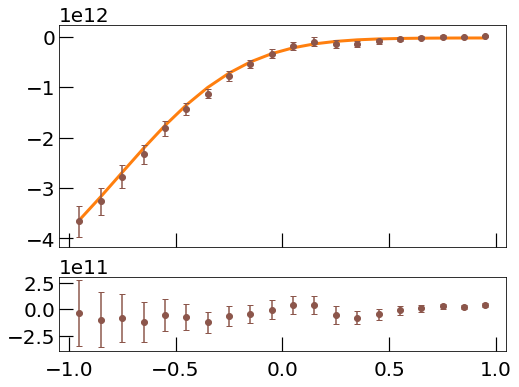

In [8]:
filename = chainsdir+"R200c_binned/Dsep_R200c/chains_M{:.2g}_{:.2g}_z{}_{}.h5py".format(mass_min, mass_max, redshift_str, 'erf')
f = h5py.File(filename,'r')
chain = np.array(f['chains'])

best_fit_params, DIC_model, BIC_model, p_val = posterior_summary_stats(chain, model_erf, 4, x_data, y_data, y_err, verbose=True)
fit = model_erf(best_fit_params[:,0], x_data)

f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8,6), sharex=True)
a0.plot(x_data, fit, label='erf', color='C1', linewidth=3)
a0.errorbar(x_data, y_data, yerr=y_err, label='Cov', marker="o", capsize=3, linestyle='None', color='C5')  
a1.errorbar(x_data, y_data-fit, yerr=y_err, marker="o", capsize=3, linestyle='None',color='C5', label='Data')

## Apply the correction term to $\Delta\Sigma$
Ingridients:
* $\beta$ the slope of the HMF at different mass and redshift pivots
* $\alpha_{\rm Ngal}$ and $\alpha_{\rm DS}$, the slopes 

In [9]:
## Plot DS and the correction term for it. 

## Some fiducial values. 
beta = 1
alpha_ngal = 1
alpha_ds = 1

DS_mean = np.mean(np.vstack(cur_df.delta_sigma), axis=0)
DS_scatter = np.std(np.vstack(cur_df.delta_sigma), axis=0)/np.sqrt(len(cur_df.delta_sigma))
correction = beta/(alpha_ngal*alpha_ds)*fit


(-2.0, 1.0)

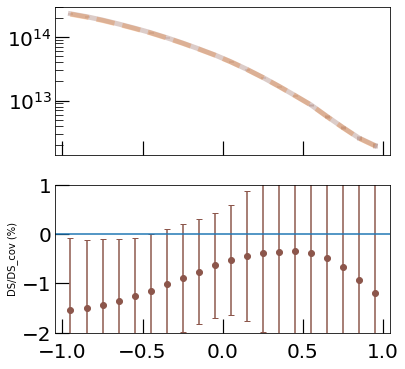

In [10]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]}, figsize=(6,6), sharex=True)
a0.errorbar(x_data, DS_mean, yerr=DS_scatter, label='Mean', color='C5', linewidth=5, alpha=0.3)
a0.plot(x_data, DS_mean + correction, label='2nd order', color='C1', linestyle='dashed', linewidth=5, alpha=0.3)
a1.errorbar(x_data, correction/DS_mean*100, yerr=DS_scatter/DS_mean*100, marker="o", capsize=3, linestyle='None',color='C5', label='Data')
a1.axhline(0)
a0.set_yscale('log')
a1.set_ylabel('DS/DS_cov (%)')
a1.set_ylim([-2,1])

In [11]:
kllr_nbins= 5
kernel_type = 'gaussian'
kernel_width = 0.1

In [12]:
## Compute the slope of DS, and richness
lm  = kllr_model(kernel_type=kernel_type, kernel_width=kernel_width)
xline, yline, intercept, slopes, scatter, skew, kurt = lm.fit(np.log10(cur_df.M200c), np.log10(cur_df.Ngal_R200c.values), \
                                                              bins=kllr_nbins, kernel_width=kernel_width, kernel_type=kernel_type, nBootstrap=1) 



1.0066270810892726


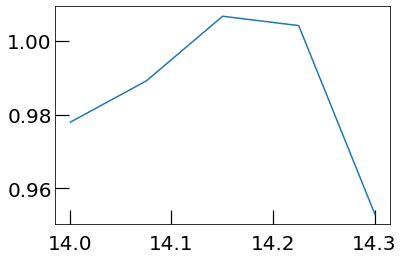

In [13]:
plt.plot(xline, slopes)

##Take the beta at the median range
median_ind = np.argsort(xline)[len(xline)//2]
print(slopes[median_ind])

In [14]:
from colossus.cosmology import cosmology
from colossus.lss import mass_function
cosmology.setCosmology('planck18')
m_grid = np.logspace(14,14.5,1000)
mfunc_so = mass_function.massFunction(m_grid, 0.5, mdef = '200c', model = 'tinker08')

Deleted outdated persistence file, no further action needed.


In [15]:
def derivative(x,y,n):
    if(n==1):
        return np.gradient(y,x)
    else:
        return np.gradient(derivative(x,y,n-1),x)

## Running across all mass and redshift

In [16]:
mass_bin_edges = [5e13, 1e14, 2e14, 5e14, 1e15]
mass_bins = [[mass_bin_edges[i],mass_bin_edges[i+1]] for i in range(len(mass_bin_edges)-1)]

a_bins = [1, 0.6712, 0.4922]

In [17]:
output_arr = np.zeros((4, 3, 20))
np.shape(output_arr)

(4, 3, 20)

In [18]:
mass_bias_arr = np.array([[0.0265, 0.02495, 0.01887],[0.02455, 0.0215, 0.02215], [0.03351, 0.01524, -0.0023], [0.02232, 0.0007, 0]])

In [19]:
def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))

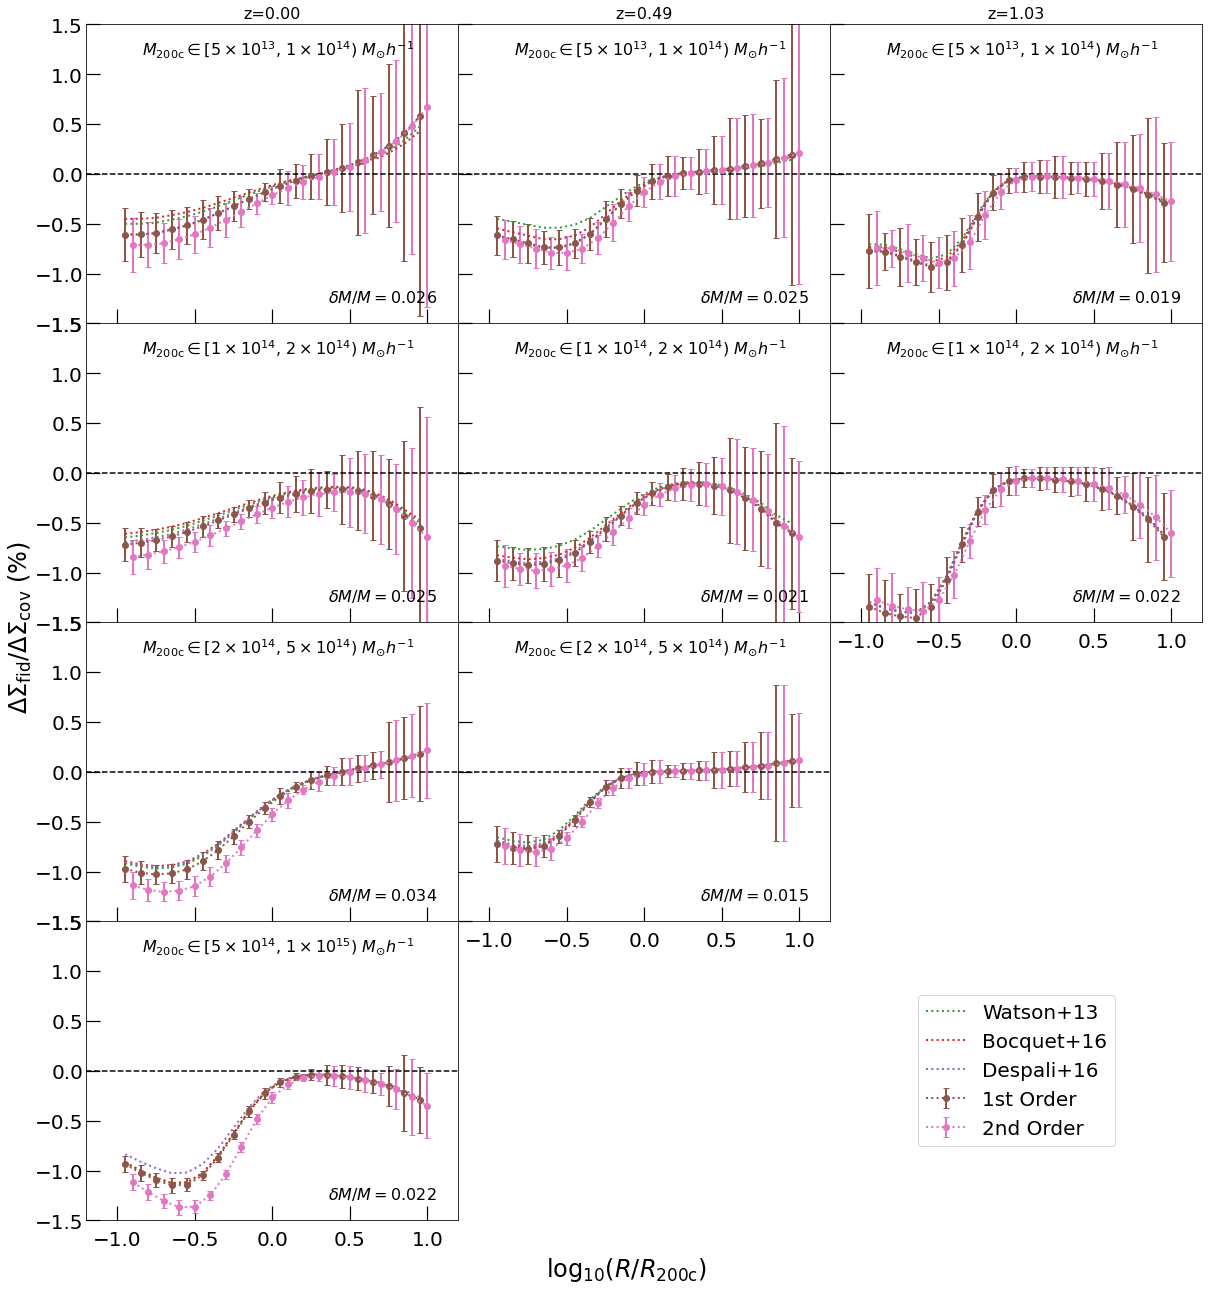

In [28]:
from scipy import stats
nBootstrap = 10
fig, axs = plt.subplots(4, 3, figsize=(20,22), sharex=False, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)
fontsize=24
legendsize = 20

for i, cur_mass_bin in enumerate(mass_bins):
    for j, cur_a_bin in enumerate(a_bins):     
        mass_min = cur_mass_bin[0]; mass_max = cur_mass_bin[1]
        mask = (matched_halo_df.M200c >= mass_min) & (matched_halo_df.M200c < mass_max) & (matched_halo_df.scale == cur_a_bin) 
        cur_df = matched_halo_df[mask]
        #print('M{:.2g}-{:.2g}, z={:.2f}, {}'.format(mass_min, mass_max, 1/cur_a_bin-1, len(cur_df)))

        redshift = 1/cur_a_bin - 1
        redshift_str = '{:.2f}'.format(redshift)
        redshift_str = redshift_str.replace('.','p')

        if len(cur_df) < 100: 
            axs[i,j].set_visible(False)
            continue

        ##Covariance data
        xline, output = calc_cov_KLLR(np.log10(np.array(cur_df['M200c'],dtype=float)) , np.array(np.vstack(cur_df['delta_sigma']), dtype=float), \
                                np.log10(np.array(cur_df['Ngal_R200c'],dtype=float)), nBootstrap=nBootstrap)
        cov_ds_ngal_kllr = output['covariance']
        cov_mean_kllr = np.mean(cov_ds_ngal_kllr, axis=0)
        cov_err_kllr = np.std(cov_ds_ngal_kllr, axis=0)

        ##Data vector for chains
        x_data = r_cent_log_norm; y_data = cov_mean_kllr; y_err = cov_err_kllr

        ###Covariance fit
        filename = chainsdir+"R200c_binned/Dsep_R200c/chains_M{:.2g}_{:.2g}_z{}_{}.h5py".format(mass_min, mass_max, redshift_str, 'erf')
        f = h5py.File(filename,'r')
        chain = np.array(f['chains'])

        best_fit_params, DIC_model, BIC_model, p_val = posterior_summary_stats(chain, model_erf, 4, x_data, y_data, y_err, verbose=False)
        fit = model_erf(best_fit_params[:,0], x_data)
        
        ########Computing the correction to the covariance
        ## Compute the slope of DS, and richness
        lm  = kllr_model(kernel_type=kernel_type, kernel_width=kernel_width)
        xline, yline, intercept, slopes, scatter, skew, kurt = lm.fit(np.log(cur_df.M200c), np.log(cur_df.Ngal_R200c.values), \
                                                                      bins=kllr_nbins, kernel_width=kernel_width, kernel_type=kernel_type, nBootstrap=1) 

        ##Take the beta at the median range
        m_mean = np.mean(np.log10(cur_df.M200c))
        
        mean_ind = (np.abs(xline - m_mean*np.log(10))).argmin()
        #median_ind = np.argsort(xline)[len(xline)//2]
        #alpha_ngal = slopes[median_ind]
        #alpha_ngal = 1
        #pi_ngal = intercept[mean_ind]
        #pi_ngal = np.mean(intercept)
        pi_ngal =np.log(40) -14.35*np.log(10) ##Pivot point
        #pi_ngal = 0 
        scatter_ngal = scatter[mean_ind]
        #print("pi_ngal = ", pi_ngal)
        #print("alpha_ngal = ", slopes[median_ind])
        #print("scatter_ngal = ", scatter[median_ind])
        
        
        ##Slope of the HMF at this mass, redshift range
        mean_ind = (np.abs(m_grid - m_mean)).argmin()
        m_grid = np.logspace(np.min(np.log10(cur_df.M200c)),np.max(np.log10(cur_df.M200c)),1000)
        mfunc_so = mass_function.massFunction(m_grid, redshift, mdef = '200c', model = 'tinker08')
        beta_1 = -1*derivative(np.log(m_grid), np.log(mfunc_so), 1)[mean_ind]
        beta_2 = -1*derivative(np.log(m_grid), np.log(mfunc_so), 2)[mean_ind]
        
        mfunc_so = mass_function.massFunction(m_grid, redshift, mdef = '200c', model = 'watson13')
        beta_1_watson13 = -1*derivative(np.log(m_grid), np.log(mfunc_so), 1)[mean_ind]
        beta_2_watson13 = -1*derivative(np.log(m_grid), np.log(mfunc_so), 2)[mean_ind]
        
        mfunc_so = mass_function.massFunction(m_grid, redshift, mdef = '200c', model = 'bocquet16')
        beta_1_bocquet16 = -1*derivative(np.log(m_grid), np.log(mfunc_so), 1)[mean_ind]
        beta_2_bocquet16 = -1*derivative(np.log(m_grid), np.log(mfunc_so), 2)[mean_ind]
        
        mfunc_so = mass_function.massFunction(m_grid, redshift, mdef = '200c', model = 'despali16')
        beta_1_despali16 = -1*derivative(np.log(m_grid), np.log(mfunc_so), 1)[mean_ind]
        beta_2_despali16 = -1*derivative(np.log(m_grid), np.log(mfunc_so), 2)[mean_ind]
        

        ## Find the median mass
        m_mean = np.mean(np.log10(cur_df.M200c))
        
        
        #median_ind = np.argsort(m_grid)[len(m_grid)//2]
        #beta_1 = beta_1[mean_ind]
        #beta_2 = beta_2[mean_ind]
        #beta_1 = np.mean(beta_1)
        #beta_2 = np.mean(beta_2)
        #print("beta_1 = ", beta_1)
        #print("beta_2 = ", beta_2)
        #print('\n')
        
        
        DS_mean = np.mean(np.vstack(cur_df.delta_sigma), axis=0)
        #DS_scatter = np.std(np.vstack(cur_df.delta_sigma), axis=0)/np.sqrt(len(cur_df.delta_sigma))
         
        ##First order correction
        correction_1 = beta_1/(alpha_ngal)*fit
        correction_1_watson13 = beta_1_watson13/(alpha_ngal)*fit
        correction_1_bocquet16 = beta_1_bocquet16/(alpha_ngal)*fit
        correction_1_despali16 = beta_1_despali16/(alpha_ngal)*fit
        
        
        ##Store into the output array
        output_arr[i,j,:] = correction_1
        
        ##2nd order correction
        X_lnl = (1 + beta_2*scatter_ngal**2)**(-1)

        delta_lnl = (np.mean(np.log(cur_df.Ngal_R200c.values))-pi_ngal)/1 - m_mean*np.log(10)
        correction_2 = X_lnl*(beta_1 + beta_2*delta_lnl)*fit
        #print("delta_lnl = ", delta_lnl)
        #print("X_lnl = ", X_lnl)
        
        
        ####Computing the mass bias
        mass_bias = mass_bias_arr[i,j]
        
        
        DS_all = np.vstack(matched_halo_df['delta_sigma'])
        axs[i,j].errorbar(x_data, correction_1/DS_mean*100, yerr=y_err/DS_mean*100, marker="o", capsize=3, linewidth=2, linestyle='dotted',color='C5', label='1st Order')
        axs[i,j].errorbar(x_data+0.05, correction_2/DS_mean*100, yerr=y_err/DS_mean*100, marker="o", capsize=3, linewidth=2, linestyle='dotted',color='C6', label='2nd Order')
        
        ##Different halo mass functions
        axs[i,j].plot(x_data, correction_1_watson13/DS_mean*100, linestyle = 'dotted', linewidth=2, color='C2', label = 'Watson+13')
        axs[i,j].plot(x_data, correction_1_bocquet16/DS_mean*100, linestyle = 'dotted', linewidth=2, color='C3', label = 'Bocquet+16')
        axs[i,j].plot(x_data, correction_1_despali16/DS_mean*100, linestyle = 'dotted', linewidth=2, color='C4', label = 'Despali+16')

        
        ##Plotting configure
        axs[i,j].axhline(0,linestyle='dashed', color='black')
        #axs[i,j].set_xscale('log'); axs[i,j].set_yscale('log')
        #axs[i,j].set_xlabel(r'$\log_{10}(R/R_{\rm 200c})$', fontsize=fontsize)
        #axs[i,j].set_title(r'$M_{\rm 200c} \in $'+'[{:.2g},{:.2g})'.format(mass_min, mass_max) + '$M_{\odot}h^{-1}$, ' + 'z={:.2f}'.format(1/cur_a_bin-1) +'\n' +
                           #'$\delta M/M =$' + '{:.3f}'.format(mass_bias), fontsize=fontsize)
        
        #y_label_on_inds = np.array([[0,1,2,3],[0,0,0,0]])
        #for ind in range(len(y_label_on_inds[0])):
        #   if (i==y_label_on_inds[0,ind]) & (j==y_label_on_inds[1,ind]): axs[i,j].set_ylabel(r'$\Delta\Sigma_{\rm fid}/\Delta\Sigma_{\rm cov}$ (%)', fontsize=fontsize)
            
        visible_off_inds = np.array([[3,2,3],[1,2,2]])
        for ind in range(len(visible_off_inds[0])):
            if (i==visible_off_inds[0,ind]) & (j==visible_off_inds[1,ind]):
                axs[i,j].set_visible(False)
                
                
        if i == 0: axs[i,j].set_title('z={:.2f}'.format(1/cur_a_bin-1), fontsize=16)
        axs[i,j].text(0.15, 0.9,  r'$M_{\rm 200c} \in $'+r'[${0:s}$, '.format(as_si(mass_min,0)) + r'${0:s}$)'.format(as_si(mass_max,0)) + ' $M_{\odot}h^{-1}$', \
                      fontsize = 16, transform=axs[i,j].transAxes)
        
        #if j == 2: axs[i,j].text(1, 0.05,  r'$M_{\rm 200c} \in $'+r'[${0:s}$, '.format(as_si(mass_min,0)) + r'${0:s}$)'.format(as_si(mass_max,0)) + ' $M_{\odot}h^{-1}$', \
        #              rotation = -90, fontsize = 16, transform=axs[i,j].transAxes)
        #if (i == 2) & (j == 1): axs[i,j].text(2, 0.05,  r'$M_{\rm 200c} \in $'+r'[${0:s}$, '.format(as_si(mass_min,0)) + r'${0:s}$)'.format(as_si(mass_max,0)) + ' $M_{\odot}h^{-1}$', \
        #              rotation = -90, fontsize = 16, transform=axs[i,j].transAxes)
        #if (i == 3) & (j == 0): axs[i,j].text(3, 0.05,  r'$M_{\rm 200c} \in $'+r'[${0:s}$, '.format(as_si(mass_min,0)) + r'${0:s}$)'.format(as_si(mass_max,0)) + ' $M_{\odot}h^{-1}$', \
        #              rotation = -90, fontsize = 16, transform=axs[i,j].transAxes) 
        axs[i,j].text(0.65, 0.07,  '$\delta M/M =$' + '{:.3f}'.format(mass_bias), fontsize = 16, transform=axs[i,j].transAxes)
        
        axs[i,j].set_ylim([-1.5,1.5])
        axs[i,j].set_xlim([-1.2,1.2])
        
axs[3,0].legend(loc='center', bbox_to_anchor=(2.5,0.5), fontsize=legendsize)

fig.text(0.5, 0.09, r'$\log_{10}(R/R_{\rm 200c})$', fontsize=fontsize, ha='center')
fig.text(0.07, 0.5, r'$\Delta\Sigma_{\rm fid}/\Delta\Sigma_{\rm cov}$ (%)', fontsize=fontsize, va='center', rotation='vertical')

plt.savefig(plotdir+'DS_cov_correction.pdf', bbox_inches='tight')
plt.show()

## Output the covariance table

In [27]:
# open a file, where you ant to store the data
file = open(datadir+'DS_binned_cov.pkl', 'wb')

# dump information to that file
pickle.dump(output_arr, file)

# close the file
file.close()